In [ ]:
b=2
import pandas as pd
import os
import logging
from collections import Counter

logging.basicConfig(level=logging.DEBUG,format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("hi")


In [ ]:

import sys
sys.path.append("../metakpick/")

import _utils_tree, _utils_kraken,_classifier, _utils
# from _utils  import get_features_read
# from _utils  import get_features_read
import importlib 
importlib.reload(_utils_tree)
importlib.reload(_utils_kraken)
importlib.reload(_classifier)
importlib.reload(_classifier)
importlib.reload(_utils)


In [ ]:
workingdir="/vast/blangme2/smajidi5/metagenomics/metakpick_project/MetaKPick/"
in_folder= workingdir+"../files/"
tree_file=in_folder+"nodes.dmp"
tax_genome_file= in_folder + "seqid2taxid.map_tax_uniq"

info, Tree, tax_index, tax_genome, parents, tree_df = _utils_tree.get_tax_info(tree_file,tax_genome_file)    




In [ ]:

#tax2path, tax2depth, tax2root_all_dic = _utils_tree.get_tax2path(tax_genome, info, parents)
tax2path, tax2depth, tax2root_all_dic, tax_genome_specieslevel = _utils_tree.get_tax2path(tax_genome, info, parents, tree_df)


In [ ]:

kraken_output_folder="../../../changek/simulatation/classification_pbsim/max15/"
cases_classify =[i.split("_")[0] for i in os.listdir(kraken_output_folder) if i.endswith('_out')]
cases_model= list(loaded_regression_dic.keys())
cases_classify_intersect=sorted(list(set(cases_classify).intersection(set(cases_model))))
kmer_list=[27,29, 31]# 19,21, 23,25
if kmer_list:   
    kmer_list_set=set(['k'+str(kmer) for kmer in kmer_list])
    cases_classify_intersect=sorted(list(set(cases_classify_intersect).intersection(set(kmer_list_set))))
logging.info("Cases in the input for classification intersected with the kmer list: "+str(cases_classify_intersect))    
    
logging.info("Cases in the input for classification: "+str(cases_classify))
logging.info("Cases in the model: "+str(cases_model))
logging.warning("Working on the intersection of cases in the input for classification and in the model: "+str(cases_classify_intersect))



In [ ]:
logging.info("Reading the kraken kmers for these cases")
read_names_list, kraken_kmers_cases = _utils_kraken.read_kraken_all(cases_classify_intersect, kraken_output_folder)
logging.info("Number of reads in the kraken kmers: "+str(len(kraken_kmers_cases)))
logging.info("Getting the tax depth")
read_tax_depth = _utils_kraken.get_tax_depth(kraken_kmers_cases, info,parents)


In [ ]:
feature_names = ['mean_nonzero', 'mean_all', 'max', 'sum', 'mean_exc_tax', 'mean_all/rlen', 'mean_nonzero/rlen', 'max/rlen', 'sum/rlen', 'mean_exc_tax/rlen', 
            'depth_reported_tax', 'Avg_kmer_consecutive', 'WAvg_kmer_consecutive', 'kmer_reported_tax', 'kmer_tax_above', 'kmer_tax_below', 
            'kmer_tax/rlen', 'kmer_tax_above/rlen', 'kmer_tax_below/rlen', 'kmer_othertax', 'kmer_othertax_above', 'kmer_othertax_below', 
            'kmer_othertax/rlen', 'kmer_othertax_above/rlen', 'kmer_othertax_below/rlen', 'diff#kmers_halfRead','rlen',
            'mean_all_path', 'mean_nonzero_path', 'max_path', 'sum_path', 'mean_exc_tax_path', 'mean_all_path/rlen', 'mean_nonzero_path/rlen', 'max_path/rlen', 'sum_path/rlen', 'mean_exc_tax_path/rlen']

In [ ]:
read_names_list2=read_names_list[:100]
import numpy as np
num_nodes_tree = len(tax2path)  # 52229
cases=list(kraken_kmers_cases.keys())
features_cases={}
not_found_in_tax2depth=[]
for case in cases: 
    logging.debug("Extracting features for case: "+case)
    kmer_size= int(case[1:])
    X3=[]
    for read_idx,read_name in enumerate(read_names_list2):
        if read_idx%20000==0:
            logging.debug("Extracting features for read idx: "+str(read_idx)+"  out of "+str(len(read_names_list)))
        reported_tax, rlen, tax_kmer_dic, tax_kmer_num_dic = kraken_kmers_cases[case].get(read_name, (0,0,{},{}))  # read length
        #if read_name not in kraken_kmers_cases[case]:
        if reported_tax==0:
            features=np.zeros(len(feature_names))
            X3.append(features)
            continue 
        kmer_reported_tax = tax_kmer_num_dic.get(reported_tax, 0)    # kraken tax may be LCA of others


In [ ]:

read_name= read_names_list2[0]
reported_tax, rlen, tax_kmer_dic, tax_kmer_num_dic = kraken_kmers_cases[case].get(read_name, (0,0,{},{}))  # read length
kmer_reported_tax = tax_kmer_num_dic.get(reported_tax, 0)    # kraken tax may be LCA of others
case, read_name, reported_tax, kmer_reported_tax


In [ ]:
#def get_features_path(Tree, tax_index, reported_tax, tax_kmer_num_dic, tax2path, rlen,num_nodes_tree):
num_kmers_path_updated= _utils_kraken.calculate_num_kmers_path(Tree, tax_kmer_num_dic, tax_index)
num_kmers_path_updated

In [ ]:
def get_features_path(Tree, tax_index, reported_tax, tax_kmer_num_dic, tax2path, rlen,num_nodes_tree):
    num_kmers_path_updated= _utils_kraken.calculate_num_kmers_path(Tree, tax_kmer_num_dic, tax_index)

    num_kmer_path_all=np.array(list(num_kmers_path_updated.values()),dtype=np.int32)
    num_kmer_norm=num_kmer_path_all/rlen # read_length_dic[read_id]

    mean_exc_tax = (np.sum(num_kmer_path_all)-num_kmers_path_updated[reported_tax])/num_nodes_tree # todo maybe divid by numebr of paths
    
    #feature_names=['mean_nonzero','mean_all','max','sum', 'mean_exc_tax']
    features_read_path=[np.mean(num_kmer_path_all),np.mean(num_kmer_path_all)*len(num_kmer_path_all)/num_nodes_tree, np.max(num_kmer_path_all),np.sum(num_kmer_path_all),mean_exc_tax]
    #feature_names+=['mean_nonzero/rlen','max/rlen','sum/rlen', 'mean_exc_tax/rlen'] # /readlength
    features_read_path+=[np.mean(num_kmer_norm)/rlen, np.mean(num_kmer_norm)*len(num_kmer_norm)/num_nodes_tree/rlen, 
                np.max(num_kmer_norm)/rlen,np.sum(num_kmer_norm)/rlen]
    return features_read_path


In [ ]:
features_read_path = _utils.get_features_path(Tree, tax_index, reported_tax, tax_kmer_num_dic, tax2path, rlen,num_nodes_tree)
features_read_path

In [ ]:
    
feature_names = ['mean_nonzero', 'mean_all', 'max', 'sum', 'mean_exc_tax', 'mean_all/rlen', 'mean_nonzero/rlen', 'max/rlen', 'sum/rlen', 'mean_exc_tax/rlen', 
            'depth_reported_tax', 'Avg_kmer_consecutive', 'WAvg_kmer_consecutive', 'kmer_reported_tax', 'kmer_tax_above', 'kmer_tax_below', 
            'kmer_tax/rlen', 'kmer_tax_above/rlen', 'kmer_tax_below/rlen', 'kmer_othertax', 'kmer_othertax_above', 'kmer_othertax_below', 
            'kmer_othertax/rlen', 'kmer_othertax_above/rlen', 'kmer_othertax_below/rlen', 'diff#kmers_halfRead','rlen',
            'path_mean_nonzero','path_mean_all','path_max','path_sum', 'path_mean_exc_tax',
            'path_mean_nonzero/rlen','path_max/rlen','path_sum/rlen', 'path_mean_exc_tax/rlen']
len(feature_names)


In [ ]:
len(['path_mean_nonzero','path_mean_all','path_max','path_sum', 'path_mean_exc_tax',
            'path_mean_nonzero/rlen','path_max/rlen','path_sum/rlen', 'path_mean_exc_tax/rlen'])

In [ ]:
# reported_tax=131567

# a= get_features_path(Tree, tax_index, reported_tax, tax_kmer_num_dic, tax2path, rlen,num_nodes_tree,info, parents)
# _utils_tree.find_tax2root(info, parents, reported_tax)
a=2
a+1

In [ ]:
Tree_updated ={node:node_set.intersection(tax_index) for node,node_set in  Tree.items() if  node in tax_index}
if 1 in Tree_updated and 1 in Tree_updated[1]:
    Tree_updated[1].remove(1)
child2parent = { }
for parent, children in Tree_updated.items():
    for child in children:
        child2parent[child]=parent
        
root=1
num_kmers_path={}


In [ ]:
tax_kmer_num_dic

In [ ]:
for read_name_id, read_name in  enumerate(read_names_list):
    if read_name_id%1000==0:
        print(read_name_id, read_name)
    reported_tax, rlen, tax_kmer_dic, tax_kmer_num_dic = kraken_kmers_cases[case].get(read_name, (0,0,{},{}))  # read length
    #kmer_reported_tax = tax_kmer_num_dic.get(reported_tax, 0)    # kraken tax may be LCA of others
    #case, read_name, reported_tax, kmer_reported_tax
    num_kmers_path={}
    _utils.traverse_from_root(root, Tree_updated, num_kmers_path,tax_kmer_num_dic, child2parent)
    #print(read_name, len(num_kmers_path))   

print(len(read_names_list2))


In [ ]:

num_kmers_path_updated ={node:accum for node, (accum,nn) in num_kmers_path.items() if accum!=0}


In [ ]:
kraken_kmers_cases31= {'k31':kraken_kmers_cases['k31']}
features_cases, feature_names = _utils.get_features_all(read_names_list, tax2path, kraken_kmers_cases31, read_tax_depth, tax2depth, info, parents, Tree, tax_index)
#get_features_all(read_names_list, tax2path,{'k31':kraken_kmers_cases['k31']}, read_tax_depth, tax2depth, info, parents, Tree, tax_index)



In [ ]:
read_names_list2[0],[float(o) for o in features_cases['k31'][0][-10:]], feature_names[-10:]

In [ ]:
np.mean(numkmer_consecutive)

In [ ]:
tax_kmer_num_dic

In [ ]:
features_read = _utils.get_features_read(tax_kmer_num_dic, num_nodes_tree, kmer_reported_tax, rlen)
features_read, len(features_read)

In [ ]:
feature_names[10:13]

In [ ]:

if reported_tax in tax2depth:
    features_depth= _utils.get_features_depth(case, read_name, read_tax_depth, tax2depth,reported_tax,tax_kmer_dic)
else:
    not_found_in_tax2depth.append((read_name,case,reported_tax))
    features_depth = [0, 0, 0]
depth_reported= features_depth[0]
depth_reported,features_depth

In [ ]:
tax_kmer_num_dic

In [ ]:
feature_names = ['mean_nonzero', 'mean_all', 'max', 'sum', 'mean_exc_tax', 'mean_all/rlen', 'mean_nonzero/rlen', 'max/rlen', 'sum/rlen', 'mean_exc_tax/rlen', 
            'depth_reported_tax', 'Avg_kmer_consecutive', 'WAvg_kmer_consecutive', 'kmer_reported_tax', 'kmer_tax_above', 'kmer_tax_below', 
            'kmer_tax/rlen', 'kmer_tax_above/rlen', 'kmer_tax_below/rlen', 'kmer_othertax', 'kmer_othertax_above', 'kmer_othertax_below', 
            'kmer_othertax/rlen', 'kmer_othertax_above/rlen', 'kmer_othertax_below/rlen', 'diff#kmers_halfRead','rlen',
            'mean_all_path', 'mean_nonzero_path', 'max_path', 'sum_path', 'mean_exc_tax_path', 'mean_all_path/rlen', 'mean_nonzero_path/rlen', 'max_path/rlen', 'sum_path/rlen', 'mean_exc_tax_path/rlen']


In [ ]:
        
    # logging.debug("feature_names are : "+str(feature_names))
    

    #         features_tax, below_tax_all_perread = get_features_tax(reported_tax, info, parents, tax_kmer_num_dic, depth_reported, tax2depth, kmer_reported_tax, rlen)

    #         feature_half_read = get_features_half_read(reported_tax, tax_kmer_dic, rlen, below_tax_all_perread)

    #         features_path=get_features_path(Tree, tax_index, reported_tax, tax_kmer_num_dic, tax2path, rlen,num_nodes_tree)


    #         features=features_read + features_depth+ features_tax+ feature_half_read + [rlen] + features_path
    #         #print(sum(features))



In [ ]:
read_names_list2=list(read_names_list)[:100]
logging.info("Getting the features")
features_cases, feature_names = _utils.get_features_all(read_names_list2, tax2path, kraken_kmers_cases, read_tax_depth, tax2depth, info, parents, tax_genome_specieslevel, tax_index)
logging.info("Cases in features: "+str(features_cases.keys()))
logging.info("Applying the model")


In [ ]:

read_k_prob= _classifier.apply_RF_model(cases_classify_intersect, features_cases,read_names_list2,loaded_regression_dic)
logging.info("Number of reads in the read_k_prob: "+str(len(read_k_prob)))  

logging.info("Getting the best tax")
best_k_dic, estimated_tax_dict = _classifier.get_best_tax(read_k_prob,read_names_list2,kraken_kmers_cases,thr_minprob=0.5) 
logging.info("Writing the estimated tax")

In [ ]:
truth_file= "../../../changek/simulatation/classification_pbsim/max15/true_tax_max15.csv"
logging.info("Reading the truth file: "+truth_file)
dic_tax_truth = _utils_kraken.read_truth_file(truth_file)
logging.info("Number of reads in the truth file: "+str(len(dic_tax_truth)))


In [ ]:
reads_tp_cases_all={}
for tax_level in ['species','genus','family','order','class']:
    reads_tp_cases_all[tax_level] = calculate_true_k(kraken_kmers_cases,dic_tax_truth,info,tree_df,parents,tax_level,tax_index,read_names_list)

logging.info("cleaning reported tax for all kmer sizes")


In [ ]:


kraken_reportedtax_cases=dict()
kraken_reportedtax_cases['RF']=estimated_tax_dict
for case in cases_classify_intersect:
    kraken_reportedtax_cases[case]={}
    for read_name, kraken_info in kraken_kmers_cases[case].items():
        reported_tax = kraken_info[0]
        kraken_reportedtax_cases[case][read_name]=reported_tax



In [ ]:
import random
kraken_reportedtax_cases["Random"]={} 
for read_name in read_names_list2:
    case_random = cases_classify_intersect[random.randint(0, len(cases_classify_intersect)-1)]
    kraken_reportedtax_cases["Random"][read_name]  = kraken_reportedtax_cases[case_random][read_name]      	     

kraken_reportedtax_cases[ "Oracle"]={}
for tax_level in ['species','genus','family','order','class']:
    kraken_reportedtax_cases[ "Oracle"][tax_level]={}
    for read_name in read_names_list:
        true_k_set= reads_tp_cases_all[tax_level][read_name]
        found_true_tax= 0
        if true_k_set:
            case_true_k = 'k'+str(list(true_k_set)[0])
            found_true_tax = kraken_reportedtax_cases[case_true_k][read_name]
        kraken_reportedtax_cases[ "Oracle"][tax_level][read_name]  = found_true_tax           	     


In [ ]:
# _utils_kraken

logging.info("Calculating the tp fp")

print("case\tF1\tprecision\trecall\tTP\tFP\tVP\tFN")
for level in ['species']: # ,'genus','family','order','class'
    print("level: "+level)
    for case in list(cases_classify_intersect)+["RF","Random","Oracle"]:
        logging.info("Calculating the tp fp for case: "+case)
        if case=='Oracle':

            dic1_ = {k: v for k, v in kraken_reportedtax_cases[case][level].items() if k in read_names_list2}
            read_tpfp_dic = calculate_tp_fp('predicted_tax',dic1_, dic_tax_truth,info,tree_df,parents,level,tax_index)
        else:
            dic1_ = {k: v for k, v in kraken_reportedtax_cases[case].items() if k in read_names_list2}
            read_tpfp_dic = calculate_tp_fp('predicted_tax',dic1_,dic_tax_truth,info,tree_df,parents,level,tax_index)
    
        logging.info("Number of reads in the TP: "+str(len(read_tpfp_dic['TP'])))

        FP=len(read_tpfp_dic['FP-level-index'])+len(read_tpfp_dic['FP-higher-index'])+len(read_tpfp_dic['FP-level-notindex'])+len(read_tpfp_dic['FP-higher-notindex'])
        recall=len(read_tpfp_dic['TP'])/(len(read_tpfp_dic['TP']) + len(read_tpfp_dic['VP']) + len(read_tpfp_dic['FN']) +FP )
        if len(read_tpfp_dic['TP'])!=0:
            precision=len(read_tpfp_dic['TP'])/(len(read_tpfp_dic['TP']) + FP)
            F1= 2* precision* recall/(precision+recall)
        else:
            precision=0
            F1=0
        print(case,'\t',round(F1,4), round(precision,4),round(recall,4),len(read_tpfp_dic['TP']),FP,len(read_tpfp_dic['VP']),len(read_tpfp_dic['FN']))

        
                

In [ ]:
len(dic1_)

In [ ]:
level='species'
case='RF'
dic1_ = {k: v for k, v in kraken_reportedtax_cases[case].items() if k in read_names_list2}
read_tpfp_dic = calculate_tp_fp('predicted_tax',dic1_,dic_tax_truth,info,tree_df,parents,level,tax_index)
FP=len(read_tpfp_dic['FP-level-index'])+len(read_tpfp_dic['FP-higher-index'])+len(read_tpfp_dic['FP-level-notindex'])+len(read_tpfp_dic['FP-higher-notindex'])
FP

In [ ]:

level='species'
case='RF'
dic1_ = {k: v for k, v in kraken_reportedtax_cases[case].items() if k in read_names_list2}
read_tpfp_dic = calculate_tp_fp('predicted_tax',dic1_,dic_tax_truth,info,tree_df,parents,level,tax_index)
FP=len(read_tpfp_dic['FP-level-index'])+len(read_tpfp_dic['FP-higher-index'])+len(read_tpfp_dic['FP-level-notindex'])+len(read_tpfp_dic['FP-higher-notindex'])
FP
for i in read_tpfp_dic['FP-level-index']:
    print(i, reads_tp_cases_all['species'][i])
print("---- FP-level-index")
for i in read_tpfp_dic['FP-higher-index']:
    print(i, reads_tp_cases_all['species'][i])
print("---- FP-higher-index ")
for i in read_tpfp_dic['FP-level-notindex']:
    print(i, reads_tp_cases_all['species'][i])
print("---- FP-level-notindex")
for i in read_tpfp_dic['FP-higher-notindex']:
    print(i, reads_tp_cases_all['species'][i])


In [ ]:
r1="NZ_CP045302.1__1_1"
#'NZ_CP083590.1__1_1'#'NZ_PP626394.1__1_1' #list(read_names_list2)[2]
print(r1, dic_tax_truth[r1], kraken_reportedtax_cases['k31'][r1], reads_tp_cases_all['species'][r1])


In [ ]:
print(kraken_reportedtax_cases['RF'][r1], kraken_reportedtax_cases['Oracle']['species'][r1])    
[float(round(i,2)) for i in read_k_prob[r1]]

In [ ]:
len(read_k_prob)

In [ ]:
import numpy as np
cases=list(kraken_kmers_cases.keys())
max_val = np.max(read_k_prob[r1])
if max_val >0.5:
    best_k = cases[np.argmax(read_k_prob[r1])]
max_val, best_k

In [ ]:
list(f)

In [ ]:
for f_idx, feature_name in enumerate(feature_names):
    readid=read_names_list2.index(r1)
    f= features_cases['k23'][readid]
    print(feature_name, round(float(f[f_idx]),4))

In [ ]:
features_cases['k31'][1][-1]

In [ ]:
tax_kmer_num_dic

In [ ]:

import copy
print(Tree[1])
Tree_updated = copy.deepcopy(Tree)
Tree_updated[1].remove(1)
Tree_updated[1]
    

In [ ]:

def traverse_from_root(current_node, input_tree, num_kmers_path, tax_kmer_num_dic):
    children_nodes = input_tree[current_node]
    #print(current_node,"number of children" ,len(children_nodes))    
    for child_node in children_nodes:
        num_kmers=num_kmers_path.get(current_node,0)+tax_kmer_num_dic.get(child_node,0)
        if num_kmers: # avoid keeping paths with zeros 
            num_kmers_path[child_node]= num_kmers
            #print(child_node,"number of kmers so far",num_kmers_path[child_node])
        if child_node in input_tree: # the child node has its own child
            traverse_from_root(child_node, input_tree, num_kmers_path,tax_kmer_num_dic)
    return 1
    

In [ ]:
a

In [ ]:
import copy
def calculate_num_kmers_path(Tree, tax_kmer_num_dic):

    if 1 in Tree and 1 in Tree[1]:
        Tree_updated = copy.deepcopy(Tree)
        Tree_updated[1].remove(1)
    else:
        Tree_updated = Tree 

    root=1
    num_kmers_path={root:tax_kmer_num_dic.get(root,0)}
    traverse_from_root(root, Tree_updated, num_kmers_path,tax_kmer_num_dic)

    return num_kmers_path



In [ ]:
root=1
num_kmers_path={}
traverse_from_root(root, Tree_updated, num_kmers_path,tax_kmer_num_dic)


In [ ]:
tax_genome_specieslevel = set()
tax_level='species'
for tax in tax_genome: # only at species level other wise I should use tax_index
    tax_taxlevel = _utils_tree.find_tax_level(info,tree_df,parents, tax, tax_level)
    if tax_taxlevel>1:   #!=1 and != -1  if the tax is species or lower
        tax_genome_specieslevel.add(tax_taxlevel)
print('number of tax genome at species ',len(tax_genome_specieslevel), 'all input ', len(tax_genome))


In [ ]:
num_kmers_path[1706369]

In [ ]:
len(num_kmers_path)

In [ ]:
list(num_kmers_path.keys())[:10]

In [ ]:
num_kmers_path[1]

In [ ]:
read_name, case

In [ ]:
read_name=list(kraken_kmers_cases[case].keys())[10]

reported_tax, rlen, tax_kmer_dic, tax_kmer_num_dic = kraken_kmers_cases[case].get(read_name, (0,0,{},{}))  # read length
len(kraken_kmers_cases[case][read_name]), len(kraken_kmers_cases),len(tax_kmer_num_dic)

num_kmers_path = calculate_num_kmers_path(Tree, tax_kmer_num_dic)


In [ ]:
len(parents), reported_tax

In [ ]:
num_kmers_path[421]

In [ ]:
tax_kmer_num_dic, len(num_kmers_path), parents[421]

In [ ]:
#_utils_tree.get_tax2path([421], info, parents)
# list(tax2root_all_dic.keys())[:2]
# ['421']
print(_utils_tree.find_tax2root(info,parents, 91347))
print(_utils_tree.find_tax2root(info,parents, 421))

In [ ]:
for tax in tax_genome_specieslevel: 
    if tax in num_kmers_path and num_kmers_path[tax]:
        parent_tax = parents[info[tax]]
        if parent_tax in num_kmers_path and num_kmers_path[parent_tax]!=num_kmers_path[tax]: # node or child has new kmers
            print(tax, num_kmers_path[tax],num_kmers_path[tax], parents[tax],  num_kmers_path[parent_tax])


In [ ]:

max_num_kmers = max(num_kmers_path.values())

max_paths=[]
for path, num_kmers in num_kmers_path.items():
    if num_kmers == max_num_kmers:
        max_paths.append(path)

print(max_paths, max_num_kmers,reported_tax)

In [ ]:
# root=1
# num_kmers_path={root:tax_kmer_num_dic.get(root,0)}
# # each path is indexed with its last node (internal or leaf)
# print(len(num_kmers_path))

# traverse_from_root(root, Tree_updated, num_kmers_path,tax_kmer_num_dic)
# print(len(num_kmers_path))

In [ ]:


# tax2path, tax2depth = get_tax2path(tax_genome, info, parents)

# folder_input =workingdir+"../../changek/simulatation/"
# truth_file=folder_input+"true_tax.csv" # generated by generate_training.ipynb

# dic_tax_truth = read_truth_file(truth_file)
# logging.info("Number of reads in the truth file: "+str(len(dic_tax_truth)))

# classification_folder=folder_input+"classification/" 
# cases=[i.split("_")[0] for i in os.listdir(classification_folder) if i.endswith('_out')] #["k"+str(k) for k in range(15,32)]

# kraken_file="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/k31_out"
# dic_kraken=read_kraken_file(kraken_file)
# #print(dic_kraken)

In [ ]:
classification_folder="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/"

cases=[i.split("_")[0] for i in os.listdir(classification_folder) if i.endswith('_out')] #["k"+str(k) for k in range(15,32)]
cases=cases[4:5]+cases[-1:]
cases

In [ ]:

# import pandas as pd
# in_folder= "../../files/"
# tree_file=in_folder+"nodes.dmp"
# tax_genome_file= in_folder + "seqid2taxid.map_tax_uniq"

# info, Tree, tax_index, tax_genome = get_tax_info(tree_file,tax_genome_file)

In [ ]:

# def get_tax_depth(kraken_kmers_cases, info, parents):
#     logging.debug("Getting the tax depth")
#     read_tax_depth={}
#     for case, kraken_kmers in kraken_kmers_cases.items(): 
#         read_tax_depth[case]={}
#         for read_name, kraken_read_info in kraken_kmers.items():
#             reported_tax=kraken_read_info[0]

input_dic= kraken_kmers_cases['k31']
tax_level='species'
read_tpfp_dic= calculate_tp_fp("raw_kraken",input_dic,dic_tax_truth,info,tree_df,parents,tax_level,tax_index)
read_tpfp_dic.keys()


In [ ]:

# def find_true_ksize(cases,merged,info,tree_df,parents,tax_index, readids_max, level='species'):
#     tp_cases_dic={}
#     for case in cases:
#         case1= 'taxon_tool_'+case
#         tp_cases_dic[case]= calculate_tp_fp(merged,info,tree_df,parents,level,case1,tax_index) #+case
#     print(len(tp_cases_dic),len(tp_cases_dic[case]))

#     return tp_cases_dic, true_k

In [ ]:
# a= "C	NZ_OZ243912.1__1_1	1885344	1253	0:557 1885344:2 0:81 1885344:7 0:27 1885344:2 0:28 1885344:3 0:121 1885344:13 0:49 1885344:8 0:35 1885344:6 0:68 1885344:27 0:133 1885344:7 0:49"

# kraken_file="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/k31_out"
# kraken_file_out="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/k31_out_test"
# file_out=open(kraken_file_out,'w')
# file_in=open(kraken_file,'r')
# dic_kraken={}
# for line in file_in: 
#     line_split=line.strip().split("\t")
#     classified ,read_id, tax_krak, read_len, tax_kmers = line_split
#     if read_id in readids_max:
#         file_out.write(line+"\n")
# file_in.close()
# file_out.close()


In [ ]:
# kraken_file="/vast/blangme2/smajidi5/metagenomics/changek/simulatation/classification/max15/k31_out"
# file_o=open(kraken_file,'r')
# dic_kraken={}
# cnt=0
# for line in file_o:
#     cnt+=1
#     line_split=line.strip().split("\t")
#     classified ,read_id, tax_krak, read_len, tax_kmers = line_split

In [8]:
    # feature_names = ['mean_all', 'mean_nonzero', 'max', 'sum', 'mean_exc_tax', 'mean_all/rlen', 'mean_nonzero/rlen', 'max/rlen', 'sum/rlen', 'mean_exc_tax/rlen', 
    #             'depth_reported_tax', 'Avg_kmer_consecutive', 'WAvg_kmer_consecutive', 'kmer_reported_tax', 'kmer_tax_above', 'kmer_tax_below', 
    #             'kmer_tax/rlen', 'kmer_tax_above/rlen', 'kmer_tax_below/rlen', 'kmer_othertax', 'kmer_othertax_above', 'kmer_othertax_below', 
    #             'kmer_othertax/rlen', 'kmer_othertax_above/rlen', 'kmer_othertax_below/rlen', 'diff#kmers_halfRead']





    feature_names = ['mean_nonzero', 'mean_all', 'max', 'sum', 'mean_exc_tax', 'mean_all/rlen', 'mean_nonzero/rlen', 'max/rlen', 'sum/rlen', 'mean_exc_tax/rlen', 
                'depth_reported_tax', 'Avg_kmer_consecutive', 'WAvg_kmer_consecutive', 'kmer_reported_tax', 'kmer_tax_above', 'kmer_tax_below', 
                'kmer_tax/rlen', 'kmer_tax_above/rlen', 'kmer_tax_below/rlen', 'kmer_othertax', 'kmer_othertax_above', 'kmer_othertax_below', 
                'kmer_othertax/rlen', 'kmer_othertax_above/rlen', 'kmer_othertax_below/rlen', 'diff#kmers_halfRead','rlen',
                'path_mean_nonzero','path_mean_all','path_max','path_sum', 'path_mean_exc_tax',
                'path_mean_nonzero/rlen','path_max/rlen','path_sum/rlen', 'path_mean_exc_tax/rlen']

In [1]:
a=2
a

2

In [4]:
import pickle
import logging
model_folder = "/vast/blangme2/smajidi5/metagenomics/metakpick_project/files/"
model_file = model_folder+"long1731_6sep.pkl" 
#"Random_Forest_regression_models20250825_093808.pkl"
loaded_regression_dic= pickle.load(open(model_file, "rb")) # [0] # this is temprorary due to a mistke  remove 

logging.info("Loading the model: "+model_file)
logging.info("Model loaded"+str(loaded_regression_dic))

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
case='k31'
individual_tree = loaded_regression_dic[case].estimators_[1]  # Get the first tree (you can choose any index)
plt.figure(figsize=(30, 30))
tree.plot_tree(individual_tree, filled=True, rounded=True,fontsize=14, feature_names=feature_names) # , class_names=class_names,
plt.tight_layout()


#plt.savefig("/vast/blangme2/smajidi5/metagenomics/_v5__tree_1_4h.png",dpi=300)


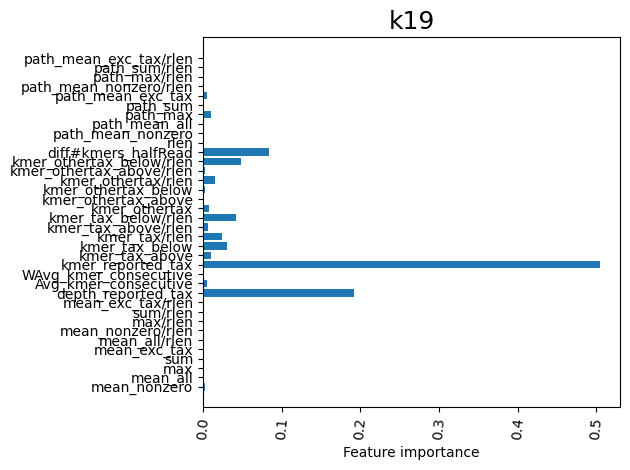

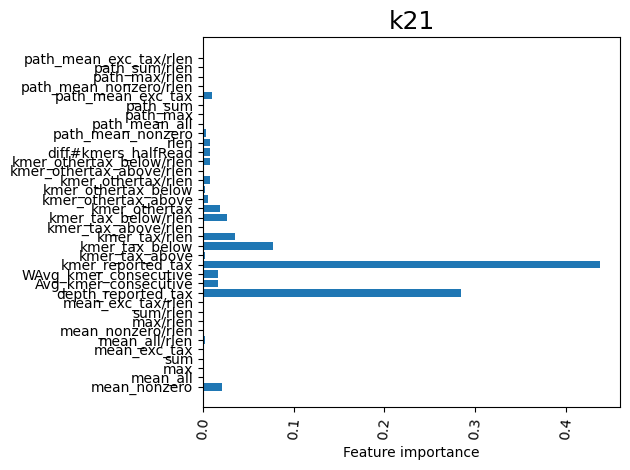

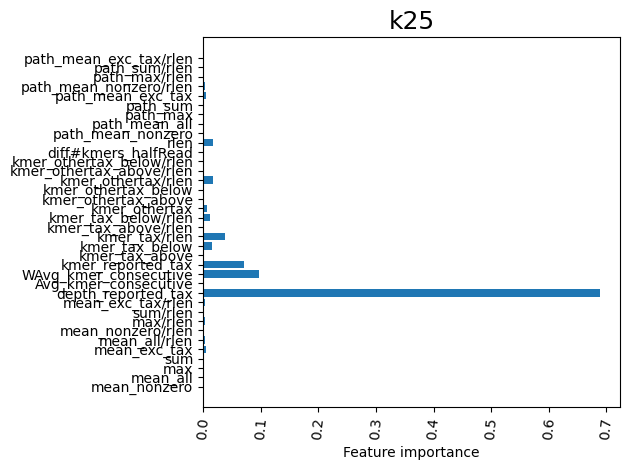

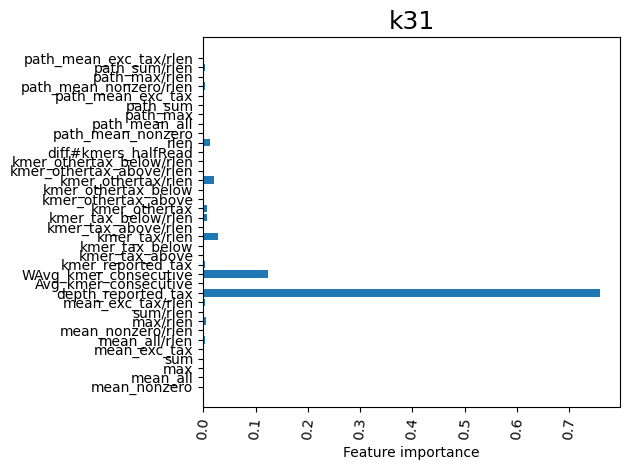

In [10]:
import matplotlib.pyplot as plt
for case in ['k19', 'k21', 'k25', 'k31']:
    
    feature_importances = loaded_regression_dic[case].feature_importances_
    fig = plt.figure()
    
    #plt.hist(feature_importances,bins=50)
    plt.barh(feature_names,feature_importances)
    #plt.yscale('log')
    plt.xlabel('Feature importance')
    #plt.ylabel('No. features')
    plt.xticks(rotation=85)
    plt.title(case,fontsize=18)
    plt.tight_layout()
    plt.savefig("/vast/blangme2/smajidi5/metagenomics/metakpick_project/runs/png/path_1731_imporantce"+case+"_.png",dpi=300)

In [ ]:

def decision_tree_to_code(tree, feature_names):

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    code_txt ="def tree({}):".format(", ".join(feature_names))+"\n"
    print(code_txt)
    def recurse_func(node, depth):
        #code_txt=""
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            code_txt = "{}if {} <= {}:".format(indent, name, threshold)+"\n"
            print(code_txt)
            recurse_func(tree_.children_left[node], depth + 1)
            code_txt = "{}else:  # if {} > {}".format(indent, name, threshold)+"\n"
            print(code_txt)
            recurse_func(tree_.children_right[node], depth + 1)
        else:
            code_txt = "{}return {}".format(indent, tree_.value[node])+"\n"
            print(code_txt)
        #print(code_txt)
        return 1

from sklearn.tree import _tree
from sklearn import tree


In [ ]:
# feature_names = ['mean_all', 'mean_nonzero', 'max', 'sum', 'mean_exc_tax', 'mean_all/rlen', 'mean_nonzero/rlen', 'max/rlen', 'sum/rlen', 'mean_exc_tax/rlen', 
#     'depth_reported_tax', 'Avg_kmer_consecutive', 'WAvg_kmer_consecutive', 'kmer_reported_tax', 'kmer_tax_above', 'kmer_tax_below', 
#     'kmer_tax/rlen', 'kmer_tax_above/rlen', 'kmer_tax_below/rlen', 'kmer_othertax', 'kmer_othertax_above', 'kmer_othertax_below', 
#     'kmer_othertax/rlen', 'kmer_othertax_above/rlen', 'kmer_othertax_below/rlen', 'diff#kmers_halfRead']


In [ ]:

import matplotlib.pyplot as plt

tree_idx=1 
regr=loaded_regression_dic['k19']    
for case,regr in regr_dic.items():
#     for tree_idx in range(num_trees):
    individual_tree = regr.estimators_[tree_idx]  # Get the first tree (you can choose any index)
    decision_tree_to_code(individual_tree,feature_names)
    plt.figure(figsize=(30, 30))
    tree.plot_tree(individual_tree, filled=True ,rounded=True,fontsize=14, feature_names=feature_names) # , class_names=class_names,
    #plt.savefig(model_folder+"/tree_"+case+"_"+str(tree_idx)+".png",dpi=200)


In [ ]:
tree_file=f+"nodes.dmp"
tax_genome_file=f+"seqid2taxid.map_tax_uniq"
logging.debug("Tree file: "+ tree_file)
tree_df = pd.read_csv(tree_file, sep="\t", header=None)

logging.debug("Read the tree file") 
children = tree_df[0]
parents = tree_df[2]
info, Tree = _utils_tree.parse_tree_file(tree_df,children,parents)
logging.debug("Parsed the tree file. Size of info: "+str(   len(info))+", Size of Tree: "+str(len(Tree)))




tax_genome_f = open(tax_genome_file,'r') # genomes in the kraken index  
tax_genome = set()
for line in tax_genome_f:
    tax_genome.add(int(line.strip()))
logging.debug('Number of genomes/strains '+str(len(tax_genome))+" in kraken index.")

tax_index_=[]
tax_notfound=[]
for tax_ in tax_genome:
    list_tax2root = _utils_tree.find_tax2root(info,parents, tax_)
    if list_tax2root!=-1:
        tax_index_ +=list_tax2root
    else:
        tax_notfound.append(tax_)
tax_index =set(tax_index_) # all the tax in genomes of kraken, plus all up to root 
logging.debug('Number of unqiue tax ids:'+str(len(tax_index))+", set size after removing duplicates: "+str(len(tax_index_))) # 
logging.debug("Genome tax not found in kraken tree "+str(tax_notfound))
out=f+"tax.ids.standard"
f_out = open(out,"w")
for t in tax_index:
    f_out.write(str(t)+"\n")
f_out.close()
    